Pixel wise segmentation using RNN's

In [1]:
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
import numpy as np

from tensorflow.keras.metrics import MeanIoU

import os

import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import glob
import PIL
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
np.random.seed(101)
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras.optimizers import Adam, SGD
import random
from tensorflow.keras.metrics import MeanIoU
import os
from tensorflow.keras.optimizers import Adam
from keras import backend, optimizers
from keras.layers import concatenate
from sklearn.metrics import roc_curve, auc
from PIL import Image
import re
from sklearn.metrics import ConfusionMatrixDisplay,f1_score
from sklearn.metrics import confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
image_files_trainx = [os.path.join('/content/gdrive/MyDrive/DRIVE/training/images', f) for f in os.listdir('/content/gdrive/MyDrive/DRIVE/training/images')]
image_files_trainy = [os.path.join('/content/gdrive/MyDrive/DRIVE/training/1st_manual', f) for f in os.listdir('/content/gdrive/MyDrive/DRIVE/training/1st_manual')]


Shape of the TIFF stack: (80, 224, 224, 3)
[[[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.00392157 0.00392157 0.00392157]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 ...

 [[0.02352941 0.02745098 0.01960784]
  [0.03529412 0.02745098 0.02352941]
  [0.03137255 0.02352941 0.02352941]
  ...
  [0.02745098 0.02745098 0.02745098]
  [0.03137255 0.03137255 0.03137255]
  [0.03529412 0.02352941 0.03137255]]

 [[0.02352941 0.01960784 0.0274

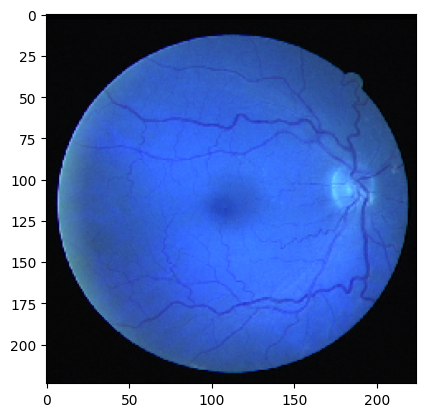

In [4]:

import skimage.io as io
from skimage import transform

resized_train_images = []
for image_path in image_files_trainx:
    image = cv2.imread(image_path)
    resized_image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_NEAREST) / 255.0
    resized_train_images.append(resized_image)

train_images = np.array(resized_train_images)
train_images = np.repeat(train_images, 4, axis=0)

print("Shape of the TIFF stack:", train_images.shape)
plt.imshow(train_images[0])

print(train_images[0])

Shape of the TIFF stack: (80, 224, 224)
[0. 1.]


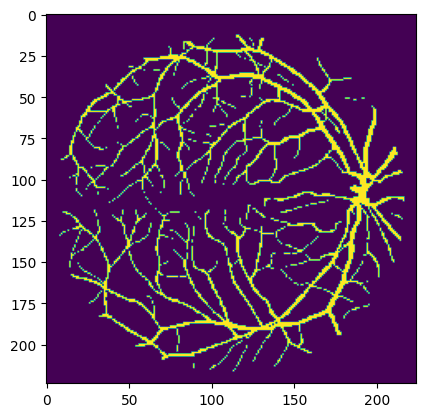

In [5]:
from PIL import Image

resized_train_masks = []
for image_path in image_files_trainy:
    #print(image_path)
    image = np.array(Image.open(image_path))
    #print(image)
    resized_image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_NEAREST) / 255.0
    resized_train_masks.append(resized_image)

train_masks = np.array(resized_train_masks)
train_masks = np.repeat(train_masks, 4, axis=0)


print("Shape of the TIFF stack:", train_masks.shape)

plt.imshow(train_masks[0])
print(np.unique(train_masks[0]))

In [6]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(train_images,train_masks,test_size=0.25,random_state=101)
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.25,random_state=101)

trainx


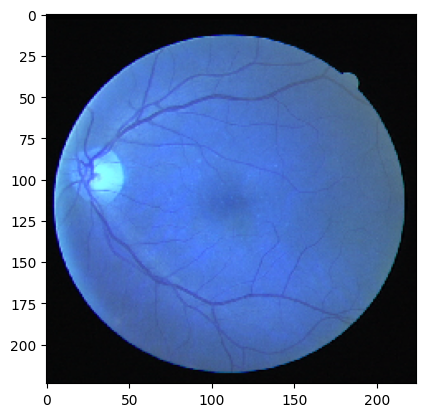

trainy


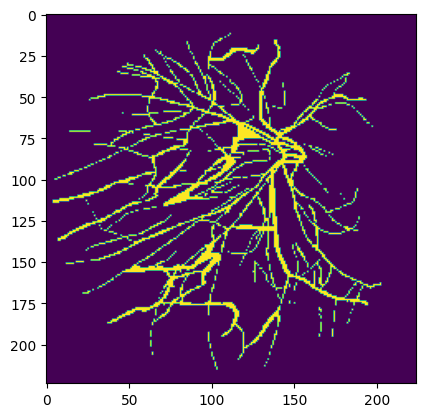

testx


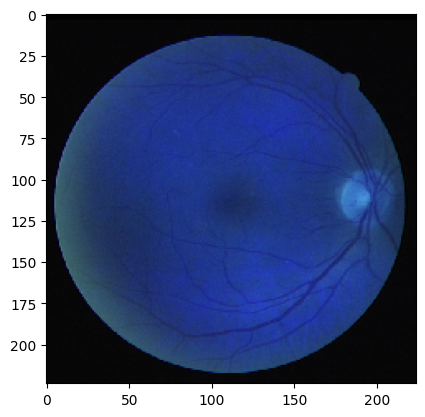

testy


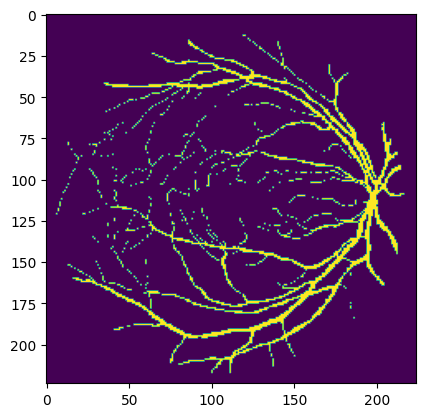

array([0., 1.])

In [7]:
# Print image from each of these foldes
print('trainx')
plt.imshow(x_train[0])
plt.show()

print('trainy')
plt.imshow(y_train[0])
plt.show()

print('testx')
plt.imshow(x_test[0])
plt.show()

print('testy')
plt.imshow(y_test[0])
plt.show()

np.unique(y_train[0])

Defining the Model

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1, 1, 3)),
    tf.keras.layers.Reshape((1, 3)),
    # Replace Conv2D layers with LSTM layer (which was present in the first pixel-wise CNN segmentation model)
    tf.keras.layers.LSTM(64, activation='relu', return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='sigmoid'))
])

model.compile(optimizer='adam',  loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 1, 3)              0         
                                                                 
 lstm (LSTM)                 (None, 1, 64)             17408     
                                                                 
 time_distributed (TimeDist  (None, 1, 1)              65        
 ributed)                                                        
                                                                 
Total params: 17473 (68.25 KB)
Trainable params: 17473 (68.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
# Reshape entire trainx and trainy into array where each elem is 1x1x3
trainx_flat = x_train.reshape(-1, 1, 1, 3)
print('overall trainx shape : ', trainx_flat.shape)
print('shape of each image : ', trainx_flat[0].shape)

trainy_flat = y_train.reshape(-1, 1, 1, 1)

x_val_flat = x_val.reshape(-1, 1, 1, 3)
y_val_flat = y_val.reshape(-1, 1, 1, 1)

overall trainx shape :  (2257920, 1, 1, 3)
shape of each image :  (1, 1, 3)


In [10]:
!pip install focal-loss

In [11]:
# Metrics.

from focal_loss import BinaryFocalLoss

def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    return K.mean(K.equal(y_true, K.round(y_pred)))

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [12]:
hist = model.fit(trainx_flat[:150], trainy_flat[:150], validation_data=(x_val_flat, y_val_flat), epochs= 15, verbose=1)

Epoch 1/15
5/5 [==============================] - 84s 21s/step - loss: 0.6922 - accuracy: 1.0000 - val_loss: 0.6925 - val_accuracy: 0.5816
Epoch 2/15
5/5 [==============================] - 38s 10s/step - loss: 0.6897 - accuracy: 1.0000 - val_loss: 0.6905 - val_accuracy: 0.9107
Epoch 3/15
5/5 [==============================] - 40s 10s/step - loss: 0.6872 - accuracy: 1.0000 - val_loss: 0.6884 - val_accuracy: 0.9118
Epoch 4/15
5/5 [==============================] - 41s 10s/step - loss: 0.6848 - accuracy: 1.0000 - val_loss: 0.6864 - val_accuracy: 0.9118
Epoch 5/15
5/5 [==============================] - 38s 10s/step - loss: 0.6823 - accuracy: 1.0000 - val_loss: 0.6843 - val_accuracy: 0.9118
Epoch 6/15
5/5 [==============================] - 38s 10s/step - loss: 0.6798 - accuracy: 1.0000 - val_loss: 0.6824 - val_accuracy: 0.9118
Epoch 7/15
5/5 [==============================] - 41s 10s/step - loss: 0.6774 - accuracy: 1.0000 - val_loss: 0.6803 - val_accuracy: 0.9118
Epoch 8/15
5/5 [===========

{'loss': [0.6922143697738647, 0.6897200345993042, 0.6872328519821167, 0.6847531795501709, 0.6822813749313354, 0.6798179149627686, 0.6773629188537598, 0.674916684627533, 0.6724792718887329, 0.670050859451294, 0.6676315069198608, 0.6652212738990784, 0.662820041179657, 0.660427987575531, 0.6580449938774109], 'accuracy': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'val_loss': [0.6925022006034851, 0.6904796361923218, 0.6883975863456726, 0.6864079833030701, 0.6843314170837402, 0.6823579668998718, 0.6802920699119568, 0.678337037563324, 0.676294207572937, 0.6743490099906921, 0.6723149418830872, 0.670386552810669, 0.6683637499809265, 0.6664462089538574, 0.6645321249961853], 'val_accuracy': [0.5815994143486023, 0.9106571674346924, 0.9118422865867615, 0.9118422865867615, 0.9118422865867615, 0.9118422865867615, 0.9118422865867615, 0.9118422865867615, 0.9118422865867615, 0.9118422865867615, 0.9118422865867615, 0.9118422865867615, 0.9118422865867615, 0.91184228658676

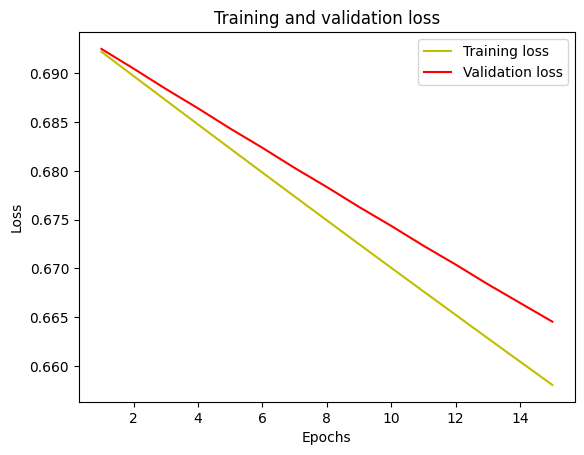

In [13]:
#plot the training and validation accuracy and loss at each epoch
history = hist
print(hist.history)
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

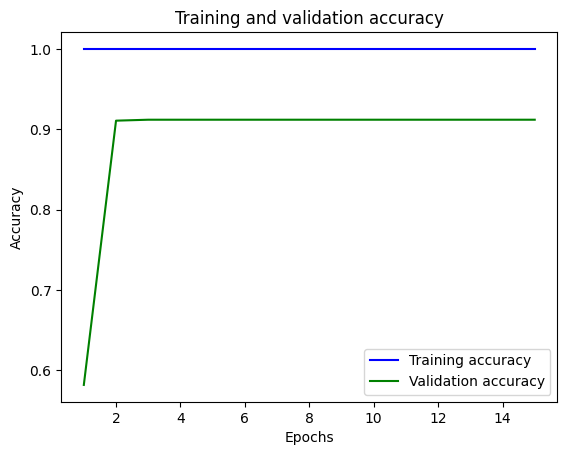

In [14]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the training and validation accuracy at each epoch
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [15]:
testx_flat = np.array(x_test).reshape(-1, 1, 1, 3)
testy_flat = np.array(y_test).reshape(-1, 1, 1, 1)

loss, accuracy = model.evaluate(testx_flat, testy_flat)

print("Model Accuracy: {}".format(accuracy * 100))


31360/31360 [==============================] - 89s 3ms/step - loss: 0.6646 - accuracy: 0.9094
Model Accuracy: 90.94377756118774


In [16]:
trainx = x_train
trainy = y_train

testx = x_test
testy = y_test

In [17]:
# All training images
sum_iou=0
i = 0
for i in range(len(trainx)):
    test_img = trainx[i]
    ground_truth=trainy[i]

    prediction = model.predict(test_img.reshape(-1, 1, 1, 3))
    prediction = tf.where(prediction >= 0.3, 0, 1)

    IOU_keras = MeanIoU(num_classes=2)
    IOU_keras.update_state(ground_truth, prediction)
    sum_iou+=IOU_keras.result().numpy()*100
    print("IoU for the current prediction =", IOU_keras.result().numpy())
m_iou_simple = sum_iou/x_train.shape[0]
print("Mean IoU: ", m_iou_simple)

1568/1568 [==============================] - 3s 2ms/step
IoU for the current prediction = 0.45143098
1568/1568 [==============================] - 5s 3ms/step
IoU for the current prediction = 0.45533723
1568/1568 [==============================] - 3s 2ms/step
IoU for the current prediction = 0.46243224
1568/1568 [==============================] - 4s 2ms/step
IoU for the current prediction = 0.45698142
1568/1568 [==============================] - 3s 2ms/step
IoU for the current prediction = 0.4509427
1568/1568 [==============================] - 3s 2ms/step
IoU for the current prediction = 0.45928332
1568/1568 [==============================] - 3s 2ms/step
IoU for the current prediction = 0.4671855
1568/1568 [==============================] - 3s 2ms/step
IoU for the current prediction = 0.46243224
1568/1568 [==============================] - 3s 2ms/step
IoU for the current prediction = 0.46958706
1568/1568 [==============================] - 3s 2ms/step
IoU for the current prediction = 0.4

In [18]:
len(trainx)

45

1568/1568 [==============================] - 3s 2ms/step


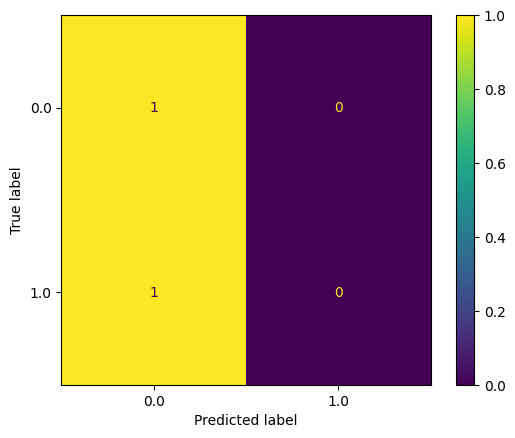

In [19]:
# For all train images
from sklearn.metrics import confusion_matrix

pred_train_array = []
for i in range(len(trainx)):
    img = model.predict(trainx[i].reshape(-1, 1, 1, 3))
    pred_train_array.append(tf.where(img >= 0.3, 0, 1))

flat_truth_arr = trainy.flatten()

flat_preds_arr = np.array(pred_train_array).flatten()
cm = confusion_matrix(flat_truth_arr, flat_preds_arr, labels=list(range(2)))
ConfusionMatrixDisplay.from_predictions(flat_truth_arr, flat_preds_arr, normalize='true')

In [20]:
# Calculating the True Positive Rate, False Positive Rate
def tpr_fpr_tnr_fnr(cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    tpr = tp/(tp+fn)
    fpr = fp/(fp+tn)
    tnr, fnr = 1-tpr, 1-fpr
    return tpr, fpr, tnr, fnr

In [21]:
tpr, fpr, tnr, fnr = tpr_fpr_tnr_fnr(cm)
print("True Positive Rate(TPR): ",tpr)
print("False Positive Rate(FPR): ",fpr)
print("True Negative Rate(TNR): ", tnr)
print("False Negative Rate(FNR): ", fnr)

True Positive Rate(TPR):  0.0
False Positive Rate(FPR):  0.0
True Negative Rate(TNR):  1.0
False Negative Rate(FNR):  1.0


In [22]:
print("F1 score of the predictions: ",f1_score(flat_truth_arr, flat_preds_arr, average='macro'))

F1 score of the predictions:  0.47810650887573963


In [23]:
# All test images
sum_iou=0
i = 0
for i in range(len(testx)):
    test_img = testx[i]
    ground_truth=testy[i]

    prediction = model.predict(test_img.reshape(-1, 1, 1, 3))
    prediction = tf.where(prediction >= 0.3, 0, 1)

    IOU_keras = MeanIoU(num_classes=2)
    IOU_keras.update_state(ground_truth, prediction)
    sum_iou+=IOU_keras.result().numpy()*100
    print("IoU for the current prediction =", IOU_keras.result().numpy())
m_iou_simple = sum_iou/testx.shape[0]
print("Mean IoU: ", m_iou_simple)

1568/1568 [==============================] - 3s 2ms/step
IoU for the current prediction = 0.4607681
1568/1568 [==============================] - 3s 2ms/step
IoU for the current prediction = 0.45928332
1568/1568 [==============================] - 3s 2ms/step
IoU for the current prediction = 0.4592335
1568/1568 [==============================] - 4s 2ms/step
IoU for the current prediction = 0.46243224
1568/1568 [==============================] - 3s 2ms/step
IoU for the current prediction = 0.44193438
1568/1568 [==============================] - 3s 2ms/step
IoU for the current prediction = 0.45433074
1568/1568 [==============================] - 4s 2ms/step
IoU for the current prediction = 0.44193438
1568/1568 [==============================] - 3s 2ms/step
IoU for the current prediction = 0.4592335
1568/1568 [==============================] - 3s 2ms/step
IoU for the current prediction = 0.45433074
1568/1568 [==============================] - 3s 2ms/step
IoU for the current prediction = 0.44

In [24]:
print(testx.shape)
# For all test images
pred_test_array = []
for i in range(testx.shape[0]):
    img = model.predict(testx[i].reshape(-1, 1, 1, 3))
    pred_train_array.append(tf.where(img >= 0.3, 0, 1))

flat_truth_arr = testy.flatten()


flat_preds_arr = np.array(pred_test_array).flatten()
print(flat_preds_arr.shape, )


(20, 224, 224, 3)
1568/1568 [==============================] - 3s 2ms/step
(0,)


In [25]:
# Calculating the True Positive Rate, False Positive Rate
def tpr_fpr_tnr_fnr(cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    tpr = tp/(tp+fn)
    fpr = fp/(fp+tn)
    tnr, fnr = 1-tpr, 1-fpr
    return tpr, fpr, tnr, fnr

In [26]:
tpr, fpr, tnr, fnr = tpr_fpr_tnr_fnr(cm)
print("True Positive Rate(TPR): ",tpr)
print("False Positive Rate(FPR): ",fpr)
print("True Negative Rate(TNR): ", tnr)
print("False Negative Rate(FNR): ", fnr)

True Positive Rate(TPR):  0.0
False Positive Rate(FPR):  0.0
True Negative Rate(TNR):  1.0
False Negative Rate(FNR):  1.0


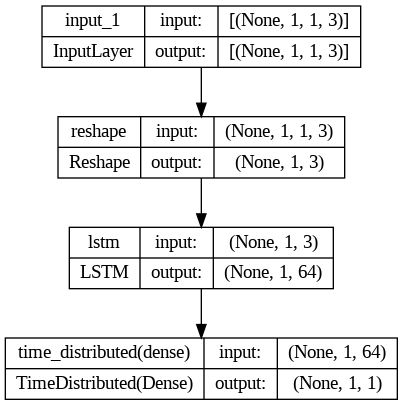

In [27]:
tf.keras.utils.plot_model(model, "model.png",show_shapes=True)

Visualization

In [35]:
viz_test_image = testx_flat[:224 * 224]
predicted_output_image = model.predict(viz_test_image)

1568/1568 [==============================] - 7s 5ms/step


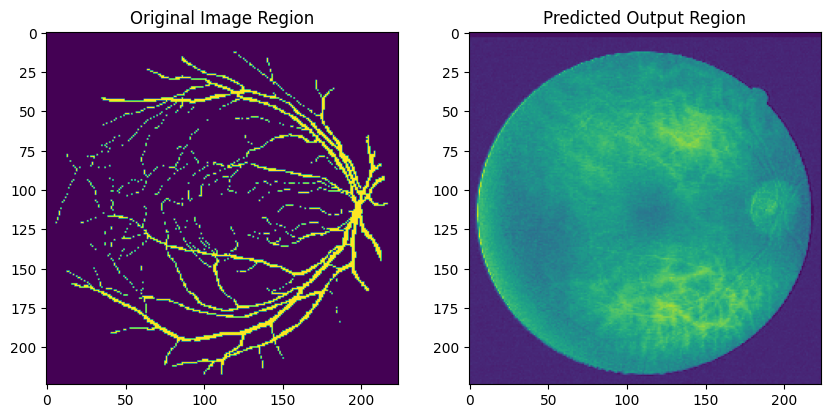

In [36]:
predicted_output_image = predicted_output_image.reshape(224, 224, 1)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(np.array(testy_flat[:224*224]).reshape(224, 224, 1))
plt.title('Original Image Region')

# Predicted image
plt.subplot(1, 2, 2)
plt.imshow(predicted_output_image)
plt.title('Predicted Output Region')

plt.show()

In [39]:
viz_test_image = testx_flat[224*224*2:224 * 224*3]
predicted_output_image = model.predict(viz_test_image)

1568/1568 [==============================] - 7s 5ms/step


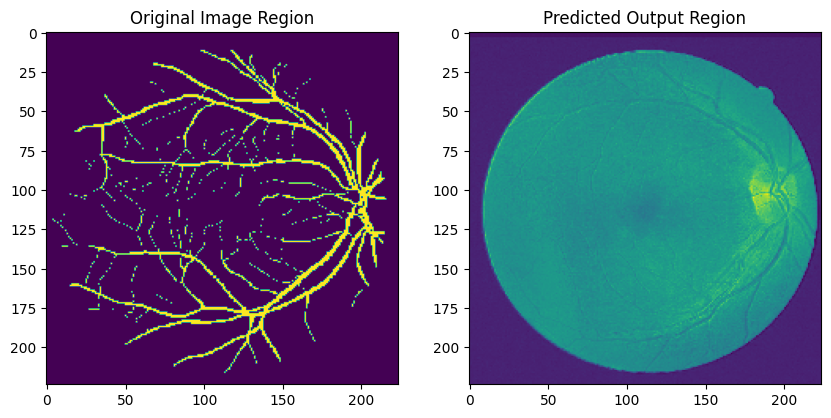

In [40]:
predicted_output_image = predicted_output_image.reshape(224, 224, 1)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(np.array(testy_flat[224*224:224*224*2]).reshape(224, 224, 1))
plt.title('Original Image Region')

# Predicted image
plt.subplot(1, 2, 2)
plt.imshow(predicted_output_image)
plt.title('Predicted Output Region')

plt.show()

In [41]:
viz_test_image = testx_flat[224*224*3:224 * 224*4]
predicted_output_image = model.predict(viz_test_image)

1568/1568 [==============================] - 4s 3ms/step


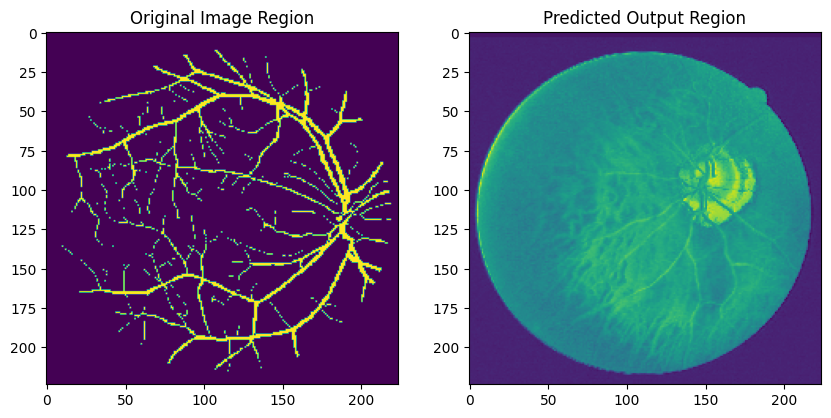

In [42]:
predicted_output_image = predicted_output_image.reshape(224, 224, 1)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(np.array(testy_flat[224*224*2:224*224*3]).reshape(224, 224, 1))
plt.title('Original Image Region')

# Predicted image
plt.subplot(1, 2, 2)
plt.imshow(predicted_output_image)
plt.title('Predicted Output Region')

plt.show()